<a href="https://colab.research.google.com/github/Abdulrahmansheier/Machine_learning_ECG/blob/main/%20IMAGE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 2: IMAGE CLASSIFICATION
The aim is to classify blood cell images into one of four classes. The procedures for training, testing, and evaluating the CNN model are implemented in this notebook.

# Importing the libraries.

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import pickle
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout


Now, we assign the train and test sets

In [ ]:
# locating training dataset and testing dataset
dataset_dir = 'blood_cell_data'
train = os.path.join(dataset_dir, 'TRAIN')
test = os.path.join(dataset_dir, 'TEST')

### Loading the Images


In [ ]:

#specs of the images
train_batch_size = 52
test_batch_size = 52
img_height = 180
img_width = 180



## --- importing the data for training ---

In [ ]:
test = tf.keras.utils.image_dataset_from_directory(
    test,
    labels='inferred',
    label_mode='int',
    classNames=['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL'],
    color_mode='rgb',
    batch_size=test_batch_size,
    image_size=(img_height, img_width),
    shuffle=True,

)
classNames = train.classNames
print(classNames)

Found 71 files belonging to 4 classes.


In [ ]:
# here i have done both the train and test the same way of implementation
# Since we are working with tensor ill have to convert the images

for x_train, y_train in train:
  break


for x_test, y_test in test:
  break


x_train.shape

TensorShape([64, 180, 180, 3])

### Data Visualization

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [ ]:
# ---  the main reason of implementing the autotune here so i can use the images in the future ---

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)



### Standardization


In [ ]:
# making the input layer smaller

normalization = layers.Rescaling(1./255)

normalized_test = test.map(lambda x, y: (normalization(x), y))
image_batch, labels_batch = next(iter(normalized_test))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.2905228 0.9663398


### Building the Model


In [ ]:
num_classes = len(classNames)
#The rescaling preprocessing layer
model = Sequential([
                      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2), #Downsamples the input along its spatial dimensions

                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),
                      layers.Dropout(0.2),

                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),

                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),
                      layers.Dropout(0.2),

                      layers.Conv2D(64, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),
                      layers.Dropout(0.2),


                      layers.Dense(128, activation='relu'),
                      layers.Flatten(),
                      layers.Dense(128, activation='relu'),  # here, we added a dense fully connected layer
                      layers.Dense(num_classes,activation='softmax')      # This dense layer produces probability values for the 2 classes

])


The model was compiled using SparsecategoricalCrossentropy and adam optimizer.

In [ ]:
# Compiling the CNN
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
model.summary()

fitting the model

In [ ]:
# Fitting the CNN to the images
epochs=200

history = model.fit(x_train,y_train, validation_split=0.1, epochs=epochs
          )

In [ ]:
accur = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accur))

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accur, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


# data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

same model applied as above, only with the input layer replaced with the data augmentation.

In [ ]:
model = Sequential([
                      data_augmentation,
                      layers.Conv2D(16, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2), #Downsamples the input along its spatial dimensions

                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),
                      layers.Dropout(0.2),

                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),

                      layers.Conv2D(32, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),
                      layers.Dropout(0.2),

                      layers.Conv2D(64, 3, padding='same', activation='relu'),
                      layers.MaxPooling2D(pool_size=2, strides=2),
                      layers.Dropout(0.2),

                      layers.Flatten(),
                      layers.Dense(64, activation='relu'),
                      layers.Flatten(),
                      layers.Dense(128, activation='relu'),  # here, we added a dense fully connected layer
                      layers.Dense(num_classes,activation='softmax')      # This dense layer produces probability values for the 2 classes

])

Compilation redone

In [ ]:
# Compiling the CNN
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fiting the model

In [ ]:
# Fitting the CNN to the images
epochs=100

history = model.fit(x_train,y_train, validation_split=0.1, epochs=epochs
          )

In [ ]:
accur = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accur))

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accur, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
# rounded_predictions = model.predict_classes(x_test, batch_size=128, verbose=0)

score = tf.nn.softmax(model.predict(x_test))
print('maximum value of the prediction: ', np.max(score))

2/2 [==============================] - 0s 11ms/step
maximum value of the prediction:  0.4063079


# confusion matrics

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = y_test
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
confusion_mtx


We plot the confusion matrix.

In [ ]:
#plotting the confusion matrix
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#print classification report
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_true, y_pred_classes, target_names=target_names))



# CONCLUSION
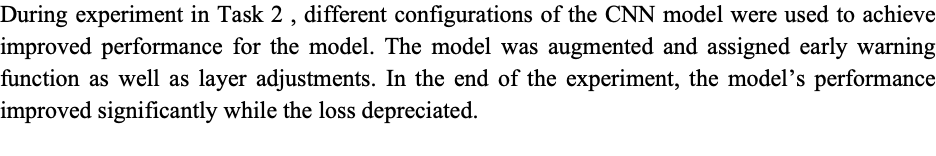

In [ ]:
# print(y_test)